In [1]:
from tabu_search.algorithm import tabu_search, NeighborsTabuListInterface, TabuSearchResult
import numpy as np
from typing import Collection, Dict, Any, Tuple, List

REPS = 30
MAX_ITERS = 1500
DPI = 150
ERROR_BAR = "sd"

# Part 1

In [2]:
def flat_manhattan_dist(loc1: int, loc2: int) -> int:
    c1 = divmod(loc1, 3)
    c2 = divmod(loc2, 3)
    return np.sum(np.abs(np.subtract(c1, c2)))


def pair_dist(csoln: str, ps: str) -> int:
    l1 = csoln.index(ps[0])
    l2 = csoln.index(ps[1])
    return flat_manhattan_dist(l1, l2)


def dist(path: List[str]) -> float:
    path = "".join(path)
    pairs = ["ad", "ac", "dc", "bc", "di", "ci", "ce", "if", "ef", "fg", "fh"]
    weights = np.array([3, 1, 1, 4, 2, 3, 7, 4, 6, 7, 8])
    pair_dists = [pair_dist(path, pair) for pair in pairs]
    return weights @ pair_dists

In [3]:
dist("abcdefghi"), dist("bidefaghc")

(85, 86)

## Tabu list methods

In [4]:
class SwapMinTabuList(NeighborsTabuListInterface):
    def __init__(self, tenure: int = 4, nbrs_size: int = 3, args: Dict | None = None):
        super().__init__(tenure, nbrs_size, args)
        self.tabu_list = []

    def neighbors(self, s_current: List) -> Tuple[Collection, Collection]:
        nbrs = []
        attrs = []

        for _ in range(self.nbrs_size):
            i1, i2 = np.random.choice(len(s_current), 2, replace=False)
            nbr = s_current.copy()
            nbr[i1], nbr[i2] = nbr[i2], nbr[i1]
            nbrs.append(nbr)
            attrs.append(sorted([i1, i2])[0])  # always add the smaller element as attribute

        return nbrs, attrs

    def add(self, attr: int, _: int):
        i1 = attr
        if len(self.tabu_list) >= self.tenure:
            self.tabu_list.pop(0)
        self.tabu_list.append(i1)

    def evaluate(self, s_current: Collection, _) -> float:
        return self.cost(s_current)

    def is_tabu(self, attr: Any, _):
        return attr in self.tabu_list

In [5]:
s0 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

res = tabu_search(dist, s0, SwapMinTabuList(4, 3, dist), MAX_ITERS)
res.cost, res.solution

(56, ['a', 'c', 'b', 'd', 'e', 'i', 'h', 'f', 'g'])

<Axes: xlabel='Iteration'>

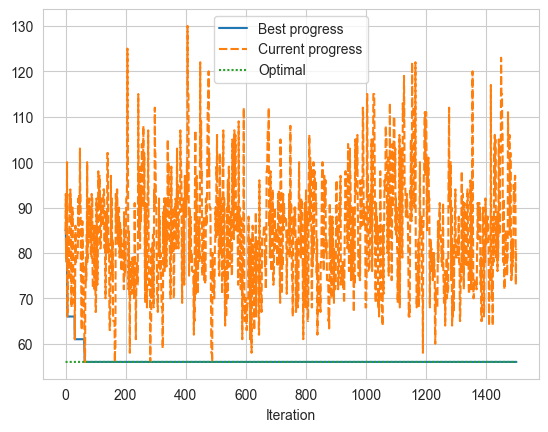

In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


def form_result(results: List[TabuSearchResult], max_iters=MAX_ITERS) -> pd.DataFrame:
    dfs = [
        pd.DataFrame({
            "Iteration": np.arange(max_iters + 1),
            "Best progress": result.progress_best,
            "Current progress": result.progress_current,
        }) for result in results
    ]
    combined = pd.concat(dfs).set_index("Iteration")
    combined["Optimal"] = 56
    return combined


sns.lineplot(form_result([res]))

In [7]:
# import itertools
# 
# all_perms = itertools.permutations("abcdefghi")
# min(all_perms, key=dist)
# dist("acbdeigfh")  # optimal

(56, ['d', 'a', 'g', 'i', 'e', 'f', 'b', 'c', 'h'])

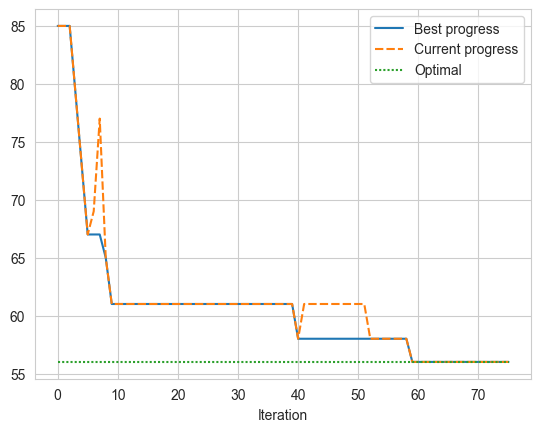

In [8]:
from tabu_search.p4 import p4_freq_tabu_search

res = p4_freq_tabu_search(s0, dist, max_iters=75)
sns.lineplot(form_result([res], 75))
res.cost, res.solution

# Part 2

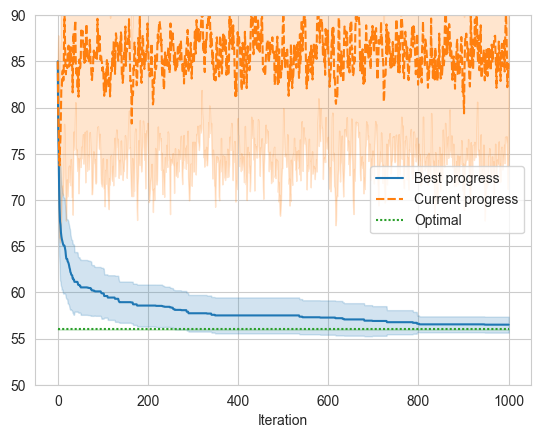

In [9]:
store_min = [tabu_search(dist, s0, SwapMinTabuList(args=dist), 1000) for _ in range(REPS)]
store_min_df = form_result(store_min, 1000)
sns.lineplot(store_min_df, errorbar=ERROR_BAR)
plt.ylim(50, 90)
plt.savefig("../../images/p4/store-min", dpi=DPI, bbox_inches="tight")

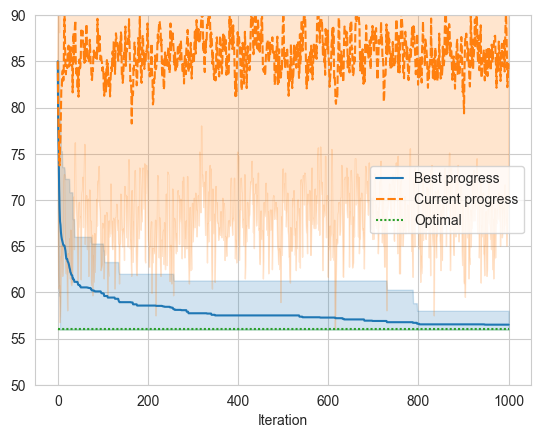

In [10]:
sns.lineplot(store_min_df, errorbar='pi')
plt.ylim(50, 90)
plt.savefig("../../images/p4/store-min-pi", dpi=DPI, bbox_inches="tight")

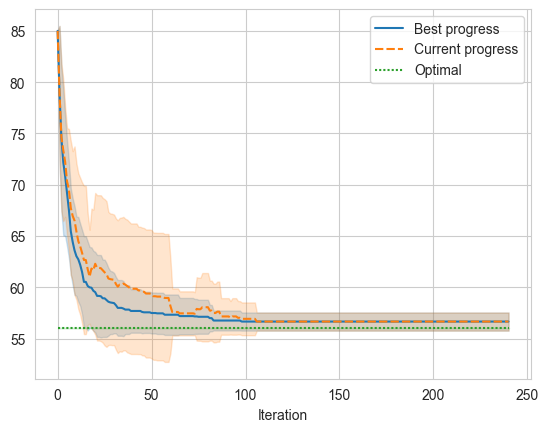

In [11]:
store_swap = [p4_freq_tabu_search(s0, dist, max_iters=240) for _ in range(REPS)]
store_swap_df = form_result(store_swap, 240)
sns.lineplot(store_swap_df, errorbar=ERROR_BAR)
plt.savefig("../../images/p4/store-swap", dpi=DPI, bbox_inches="tight")

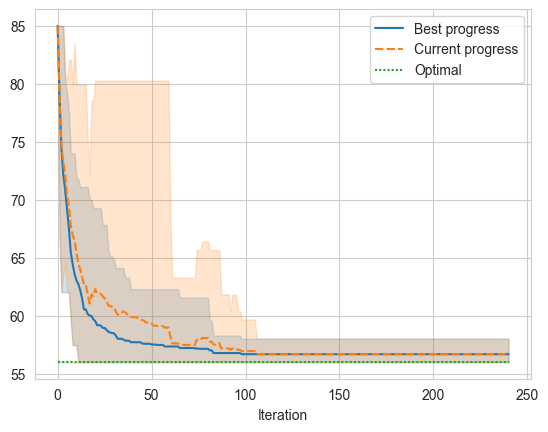

In [12]:
sns.lineplot(store_swap_df, errorbar='pi')
plt.savefig("../../images/p4/store-swap-pi", dpi=DPI, bbox_inches="tight")

In [13]:
def sim_until_opt():
    i = 0
    cost = None
    while cost is None or cost > 56:  # keeps running until optimal solution is found
        cost = p4_freq_tabu_search(s0, dist, max_iters=75).cost
        i += 1
    return i


sim_results = [sim_until_opt() for _ in range(1_000)]
np.mean(sim_results)

1.663